# Grilla que permite probar y visualizar varios modelos del predicción de LSTM

In [ ]:
# Access files from your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/Universidad/2020/Tesis_final/Codigos/Data_AQP/

/content/gdrive/MyDrive/Universidad/2020/Tesis_final/Codigos/Data_AQP


In [ ]:
pip install xlsxwriter

     |████████████████████████████████| 153kB 13.2MB/s 


In [ ]:
#imports
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from joblib import dump, load
import xlsxwriter
import openpyxl
import timeit

In [ ]:
def cargarData1():
  trainDFScaled = pd.read_csv('trainScaledDF.csv', header=0)
  testDFScaled = pd.read_csv('testScaledDF.csv', header=0)
  trainDF = pd.read_csv('trainDF.csv', header=0)
  testDF = pd.read_csv('testDF.csv', header=0)
  return trainDFScaled, testDFScaled, trainDF, testDF


In [ ]:
trainDFScaled, testDFScaled, trainDF, testDF = cargarData1()

In [ ]:
def createExcelNARX(name_file):
  # Cretae a xlsx file
  xlsx_File = xlsxwriter.Workbook(name_file)

  # Add new worksheet
  sheet_schedule = xlsx_File.add_worksheet()

  # write into the worksheet
  sheet_schedule.write('A1', 'MAE')
  sheet_schedule.write('B1', 'delayedSteps')
  sheet_schedule.write('C1', 'nameModel')
  sheet_schedule.write('D1', 'nameConfiguration')
  sheet_schedule.write('E1', 'timeTrain (in seconds)')

  # Close the Excel file
  xlsx_File.close()


# calculate the error between an actual and predicted value
def calculate_error(actual, predicted):
	# calculate abs difference
	return abs(actual - predicted)


def evaluate_forecasts(predictions, testData):
  total_mae = 0.0
  total_c = 0
  for i in range(len(predictions)):
    real = testData[i]
    predicted = predictions[i]
    # calculate error
    error = calculate_error(real, predicted)
    # update statistics
    total_mae += error
    total_c += 1
  # normalize summed absolute errors
  total_mae /= total_c
  return total_mae


def generateSupervisedData(data, delays, predictionHorizon, columnTarget = 45):
  cont = 0
  X = list()
  y = list()

  #Se va a iterar para cada fragmento de datos
  values = data.values
  chunk_ids = np.unique(values[:, 0])
  for chunk_id in chunk_ids:
    rows = data.loc[(data['chunkID'] == chunk_id)]
    #print(rows)
    cantidadFilas = rows.shape[0]
    indexAux = 0
    indexTarget = 0
    for _, row in rows.iterrows():
      end_row = indexAux + delays
      indexTarget = end_row - 1 + predictionHorizon
      if indexTarget <= cantidadFilas-1:
        salidaAux = rows.iloc[indexTarget, columnTarget]
        xAux = rows.iloc[indexAux:end_row, :].values
        #print(xAux.shape)
        #print(xAux)
        X.append(xAux)
        y.append(salidaAux)
        #print(salidaAux)
      indexAux = indexAux + 1
    cont = cont + 1
  X = np.array(X)
  y = np.array(y)
  return X, y

def reshapeXdata(trainXScaled, testXScaled):
  #reshape data
  trainXScaled = trainXScaled.reshape((trainXScaled.shape[0],trainXScaled.shape[1]*trainXScaled.shape[2]))
  #print("trainXScaled.shape: ", str(trainXScaled.shape))
  testXScaled = testXScaled.reshape((testXScaled.shape[0],testXScaled.shape[1]*testXScaled.shape[2]))
  #print("testXScaled.shape: ", str(testXScaled.shape))
  return trainXScaled, testXScaled


def generateFinalData(delays, predictionHorizon, trainDFScaled, testDFScaled, trainDF, testDF):
  trainXScaled, trainYScaled = generateSupervisedData(trainDFScaled, delays, predictionHorizon)
  testXScaled, testYScaled = generateSupervisedData(testDFScaled, delays, predictionHorizon)
  trainX, trainY = generateSupervisedData(trainDF, delays, predictionHorizon)
  testX, testY = generateSupervisedData(testDF, delays, predictionHorizon)
  #print("trainXScaled.shape: ", str(trainXScaled.shape))
  #print("trainYScaled.shape: ", str(trainYScaled.shape))
  #print("testXScaled.shape: ", str(testXScaled.shape))
  #print("testYScaled.shape: ", str(testYScaled.shape))
  #print("trainX.shape: ", str(trainX.shape))
  #print("trainY.shape: ", str(trainY.shape))
  #print("testX.shape: ", str(testX.shape))
  #print("testY.shape: ", str(testY.shape))
  trainXScaled, testXScaled = reshapeXdata(trainXScaled, testXScaled)
  return trainXScaled, trainY, testXScaled, testY


def escribirGrillaExcel(data, nameFile):
  my_file = nameFile
  my_wb_obj = openpyxl.load_workbook(my_file)
  my_sheet_obj = my_wb_obj.active

  row = my_sheet_obj.max_row + 1
  column = 1

  # Iterating through data list
  for elem in data:
    my_sheet_obj.cell(row=row, column=column).value = elem
    column += 1

  my_wb_obj.save(nameFile)




In [ ]:
#funcion que crea un diccionario con la configuracion ingresada como paramentros de entrada
def generateConfigurationDictionary(nInputs, nOutputs, Kernel, Gamma, C, Epsilon, Delays, PredictionHorizon):
  configDict = {
      "nInputs": nInputs, #Corresponde a una tupla
      "nOutputs": nOutputs, #Corresponde a un escalar
      "Kernel": Kernel, #Corresponde a un string
      "Gamma": Gamma, #Corresponde a un string
      "C": C, #valor positivo
      "Epsilon": Epsilon, #valor entre 0 y 1
      "Delays": Delays, 
      "PredictionHorizon": PredictionHorizon
      }
  return configDict

In [ ]:
def generateMultipleModelSVR(trainXScaled, trainY, testXScaled, testY, delay, horizon, nameExcelFile):
  #para crear una configuracion, las siguientes variables se pasan como escalares
  nInputs = trainXScaled.shape[1]
  nOutputs = 1
  Kernel = ['poly', 'rbf', 'sigmoid', 'linear']
  Gamma = ['scale', 'auto']
  C = [0.1, 0.3, 0.5, 0.8, 1]
  Epsilon = [0.1, 0.2, 0.3, 0.4, 0.6, 0.9]

  #contador = 2
  for K in Kernel:
    for G in Gamma:
      for Cs in C:
        for E in Epsilon:
          #if contador > 33:
          configDict = generateConfigurationDictionary(nInputs, nOutputs, K, G, Cs, E, delay, horizon)
          aplicateSVR(configDict, trainXScaled, trainY, testXScaled, testY, nameExcelFile)
          #contador = contador + 1

In [ ]:
def generateOneModelSVR(trainXScaled, trainY, testXScaled, testY, delay, horizon, nameExcelFile):
  #para crear una configuracion, las siguientes variables se pasan como escalares
  nInputs = trainXScaled.shape[1]
  nOutputs = 1
  #Kernel = ['poly', 'rbf', 'sigmoid', 'linear']
  Kernel = ['linear']
  Gamma = ['scale', 'auto']
  C = [0.1, 0.5, 1, 4, 100 ]
  Epsilon = [0.1, 0.4, 0.6, 0.9]


  configDict = generateConfigurationDictionary(nInputs, nOutputs, Kernel[0], Gamma[0], C[0], Epsilon[0], delay, horizon)
  aplicateSVR(configDict, trainXScaled, trainY, testXScaled, testY, nameExcelFile)



In [ ]:
def aplicateSVR(configDict, trainXScaled, trainY, testXScaled, testY, nameExcelFile):
  #generate name best model
  
  nameModel1 = "SVR_"+str(configDict['nInputs'])+ "_"+str(configDict['nOutputs'])+"_"+configDict['Kernel']+ "_" + configDict['Gamma'] +"_"+str(configDict['C'])
  nameModel1 = nameModel1 + "_"+str(configDict['Epsilon'])+"_"+str(configDict['Delays'])+ "S"
  nameModel = nameModel1 + ".joblib"

  #print(nameModel1)


  regressor = SVR(kernel = configDict['Kernel'], gamma = configDict['Gamma'], C = configDict['C'], epsilon = configDict['Epsilon'])
  

  
  #train the model
  startTrainTime = timeit.default_timer()

  regressor.fit(trainXScaled, trainY)


  #Your statements here

  stopTrainTime = timeit.default_timer()
  totalTime = stopTrainTime - startTrainTime
  totalTime = float("{:.2f}".format(totalTime))

  
  # Make predictions using the testing set
  y_pred_LR = regressor.predict(testXScaled)
  
  mae = evaluate_forecasts(y_pred_LR, testY)
  #print("MAE: " + str(mae))


  #Guardar modelo
  dump(regressor, nameModel) 

  #Para cargar modelo:
  #clf = load('filename.joblib') 

  #save config
  nameConfig = nameModel1 + "_config.npy"
  np.save(nameConfig,configDict)


  #para recuperar configDict
  #config=np.load(nameConfig,allow_pickle='TRUE').item()
  #print(config)

  #escribir archivo csv con configuracion, mae y nombres de archivos (mejor modelo e historia)
  dataToWrite = [mae, configDict['Delays'], nameModel, nameConfig, totalTime]
  escribirGrillaExcel(dataToWrite, nameExcelFile)


In [ ]:
def runMultipleSVR(trainDFScaled, testDFScaled, trainDF, testDF, nameFile, stepsAR):
  #Se procede a generar los ciclos que permiten ejecutar multiples pruebas
  #stepsAR = [2,4,8,16,24,32]
  #stepsAR = [24]
  predictionHorizon = 24
  for stepAR in stepsAR:
    #Generar data estructurada
    trainXScaled, trainY, testXScaled, testY = generateFinalData(stepAR, predictionHorizon, trainDFScaled, testDFScaled, trainDF, testDF)

    #probar multiples modelos
    generateMultipleModelSVR(trainXScaled, trainY, testXScaled, testY, stepAR, predictionHorizon, nameFile)

In [ ]:
def runOneSVR(trainDFScaled, testDFScaled, trainDF, testDF, nameFile, stepsAR):
  #Se procede a generar los ciclos que permiten ejecutar multiples pruebas
  #stepsAR = [2,4,8,16,24,32]
  #stepsAR = [24]
  predictionHorizon = 24
  for stepAR in stepsAR:
    #Generar data estructurada
    trainXScaled, trainY, testXScaled, testY = generateFinalData(stepAR, predictionHorizon, trainDFScaled, testDFScaled, trainDF, testDF)

    #probar multiples modelos MLP
    generateOneModelSVR(trainXScaled, trainY, testXScaled, testY, stepAR, predictionHorizon, nameFile)

In [ ]:
cd ..

/content/gdrive/My Drive/Universidad/2020/Tesis_final/Codigos


In [ ]:
cd resultados_grilla_SVR_NARX_16STEPS

/content/gdrive/My Drive/Universidad/2020/Tesis_final/Codigos/resultados_grilla_SVR_NARX_16STEPS


In [ ]:
stepsAR = [16]
nameFileSVR = "grilla_SVR_NARX_16STEPS_4.xlsx"
createExcelNARX(nameFileSVR)
runMultipleSVR(trainDFScaled, testDFScaled, trainDF, testDF, nameFileSVR, stepsAR)

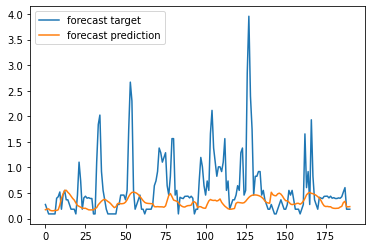

In [ ]:
#Para cargar modelo:
bestModel = load('SVR_92_1_rbf_auto_0.1_0.1_2S.joblib')
trainXScaled, trainY, testXScaled, testY = generateFinalData(2, 24, trainDFScaled, testDFScaled, trainDF, testDF)

# Make predictions using the testing set
y_pred_LR = bestModel.predict(testXScaled)

mae = evaluate_forecasts(y_pred_LR, testY)
print("MAE: " + str(mae))

import matplotlib.pyplot as plt
validation_target = testY[:191]
validation_predictions = bestModel.predict(testXScaled[:191,:])
fig, ax = plt.subplots(1, 1)
ax.plot(validation_target, label='forecast target')
ax.plot(validation_predictions, label='forecast prediction')
ax.legend()

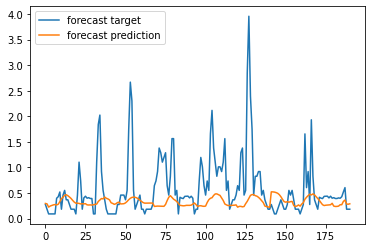

In [ ]:
#stepsAR = [2,4,8,16,24,32]
stepsAR = [2]
nameFileSVR = "grilla_SVR_NARX_2STEPS.xlsx"
createExcelNARX(nameFileSVR)
runOneSVR(trainDFScaled, testDFScaled, trainDF, testDF, nameFileSVR, stepsAR)